<a href="https://colab.research.google.com/github/shkamiya/deq/blob/master/Chapter_5_Differentiable_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5: Differentiable optimization

## Introduction: optimization solutions as layers

In previous chapters of the this tutorial, we have considered implicit layers such as Deep Equilibrium Models and Neural ODEs, which all impose a certain type of structure on the on the nature of the layer.  Another common instance of a highly-related type of structure we can impose is to define layers as the _solution_ to optimization problems.  This treatment requires a bit of clarification beforehand, namely because "optimization" in the machine learning context almost always refers to the learning process of fitting parameters to data (e.g., optimizing the parameters of a deep network, including those with DEQ or Neural ODE layers).  This is not what we are refering to in this section.  Rather, we're talking about layers that solve _small_ (or else the network would take too long to actually perform a forward pass) optimization problems as the layer's function itself.

To make this a bit more formal, we can define a generic optimization problem in the following manner
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\begin{split}
\minimize_z \;\; & f(z,x) \\
\mbox{subject to} \;\; & z \in \mathcal{C}(x)
\end{split}
\end{equation}
where $z \in \mathbb{R}^n$ the optimization variable; $x \in \mathbb{R}^m$ denotes additional problem data that defines the optimization problem; $f : \mathbb{R}^n \times \mathbb{R}^m \rightarrow \mathbb{R}$ is the objective function and $C(x) \subseteq \mathbb{R}^n$ denotes a constraint set.  In other words, the input $x$ defines both the optimization objective and the constraint set, and then we find the $z$ variable that minimizes the resulting objective while satisfying the constraints.

We can now define the output of an optimization layer as _the optimal solution (the is, the value $z^\star$ that attains the optimum of the constrained optimization problem) given the problem defined by the input $x$_.  In other words, we can definte the layer as
\begin{equation}
\DeclareMathOperator*{\argmin}{argmin}
z^\star(x) = \argmin_{z \in \mathcal{C}(x)} f(z,x)
\end{equation}
where $\argmin$ denote the value of the variable $z$ the achieves the minimum.

There are a number of applications for differentiable optimization layers both as component of "traditional" deep networks, and in their own right.  [TODO] Mention: field of bi-level optimization; our work in OptNet and follow-on work; Deep Declarative Networks; differentiable optimization in control.  Below, we will additionally highlight some simple results showing that many common (and not-so-common) nonlinearities used in deep learning can in fact be interpreted as solutions to optimization problems; doing so often highlights a new perpective on the precise "objective" of each layer in a ddep network.  We will also highlight a few simple illustrations of using these layers to learn "hard constraints" from data, a task that is often challenging for many modern networks.

## Convex optimization problems

To make our task simpler than the case of all generic optimization problems (which in general can be extremely difficult to solve), we will focus on the specific subset of _convex_ optimization problems.  Convex problems have a few desirable properties, namely that they (often) allow for efficient (i.e. polynomial time) solutions methods for finding _globally_ optimal solutions to the problems.  More relevant for the purposes of this tutorial is the practical fact that there exist off-the-shelf solvers for many classes of convex optimization problems, and that there are domain-specific modeling languages that allow one to easily specify these problems in a "natural" form, that can then be parsed such that the problem can be solved via one of theese off-the-shelf solvers.

For the purposes of this tutorial, we'll consider a fairly general form of convex optimization problem, which will capture most of the cases of interesst to us (note that this section will present this material somewhat informally, without any discussion of the subtler issues of convex analysis related to theses problems).  Specifically, we consider a convex optimization problems of the form
\begin{equation}
\begin{split}
\minimize_z \;\; & f(z) \\
\mbox{subject to} \;\; & g(z) \leq 0 \\
& h(z) = 0,
\end{split}
\end{equation}
where $z \in \mathbb{R}^n$ is the optimization variable, $f : \mathbb{R}^n \rightarrow \mathbb{R}$ is the objective function, $g : \mathbb{R}^n \rightarrow \mathbb{R}^m$ is the (vector-valued) set of inequality constraints, and $h : \mathbb{R}^n \rightarrow \mathbb{R}^p$ is a (vector-valued) set of equality constraints.  In order for this problem to be a convex optimization problem, it is required that:
1. The function $f(z)$ and each element $g_i(z)$ be convex functions. Briefly, $f$ is convex if for every $x,y \in \mbox{dom}(f)$ and $\theta \in [0,1]$,
\begin{equation}
(\theta x + (1-\theta)y) \leq \theta f(x) + (1-\theta) f(y).
\end{equation}
We'll assume basic familiarity with convex optimization here, and refer readers to [[Boyd and Vandenberghe, 2004](https://web.stanford.edu/~boyd/cvxbook/)] for a longer overview.
2. The function $h(z)$ must be _affine_, i.e., of the form $h(z) = A z + b$ for $A \in \mathbb{R}^{p \times n}$, $b \in \mathbb{R}^p$.

One of the most practically compelling aspects of convex optimization is the fact that we can easily describe conditions that guarantee _global_ optimality of the underlying optimization problem.  For example, in the cases of an unconstrained optimization problem with differentiable objective $f$, a simple condition to guarantee optimality is the zero-gradient condition, i.e., if we find a point $z^\star$ such that
\begin{equation}
\nabla f(z^\star) = 0
\end{equation}
then $z^\star$ is a global solution to the optimization problem.  For inequality and equality constrained problems like the one above, there is a generalization of this condition, known as the Karush-Kuhn-Tucker (KKT) conditions.  These state that iff we can find $(z^\star,\lambda^\star, \nu^\star)$ such that following five conditions hold
\begin{equation}
\begin{split}
g(z^\star) & \leq 0 \\
h(z^\star) & = 0 \\
\lambda^\star & \geq 0 \\
\lambda^\star \circ g(z^\star) & = 0 \\
\nabla f(z^\star) + \sum_{i=1}^m \lambda_i^\star \nabla g_i(z^\star) + \sum_{i=1}^p \nu_i^\star \nabla h_i(z^\star) & = 0
\end{split}
\end{equation}
where $\circ$ denotes the Hadamard product (elementwise multiplication) of two vectors.  Here $\lambda$ and $\nu$ are what are called _dual variables_ (whereas $z$ are called primal variabless), and the KKT conditions describe necessary and sufficient conditions for an optimal primal-dual pair.

### Solving convex optimization problems (in practice)

As mentioned above, one of the key aspects of convex optimization is that, although it can be quite involved to develop general-purpose solvers capable of robustly solving different classes of convex problems, there exist easy-to-use libraries for quickly specifying problems and then passing these to well-tuned solvers.  The particular library that we will use here is the [cvxpy](http://cvxpy.org) library [[Diamond and Boyd,2016](https://web.stanford.edu/~boyd/papers/pdf/cvxpy_paper.pdf), [Agarwal et al., 2018](https://web.stanford.edu/~boyd/papers/pdf/cvxpy_rewriting.pdf)].  This library provides a concise interface for specifying and solving optimization problems within Python.  For example, here is a quick illustration of using cvxpy to solve a non-negative least-squares problem with $\ell_1$ regularization.

In [ ]:
import cvxpy as cp
import numpy as np

m,n = 50,10
A = np.random.randn(m,n)
b = np.random.randn(m)
x = cp.Variable(n)
lam = 0.1

f = cp.sum_squares(A@x - b) + lam*cp.norm1(x)
cons = [x >= 0]
cp.Problem(cp.Minimize(f), cons).solve(verbose=False, eps_abs=1e-8, eps_rel=1e-8)
print(np.round(x.value,5))

[-0.       0.0294   0.       0.06528 -0.       0.23629 -0.      -0.
 -0.      -0.     ]


Note that with cvxpy, we don't need to specify optimization form exactly in terms of $g$ or $h$ functions as specified above, but can generally just specify the constraints as a list, in a natural manner.  Behind the scenes, cvxpy converts these problems to so-called _cone programs_ that can be solved by a variety of solvers depending on the different type of cone involved (e.g., positive cone, second order cone, semidefinite cone, or the exponential code).  However, the details of theses transformations will be unimportant for the discussion below. Furthermore, we can get not just the primal but also the dual solutions (in this case, the $\lambda$ variables), corresponding to each constraint.

In [ ]:
print(np.round(cons[0].dual_value, 5))

[ 3.18426  0.      10.78774  0.       3.6743   0.       0.93088 21.02245
  5.42407 14.82586]


## Differentiable convex optimization

Now that we have the ability to solve convex optimization problem (albeit simply by calling an existing solver), we can discuss what is needed to make the problems differentiable.  Merging the notaton of the previous two section slightly, we'll consider a convex optimizaton problem where each function $f,g,h$ is function of both the optimization variable $z$ and the input to the layer $x$ (i.e., where $x$ effectively determines the form of the functions).  Specifically, we consider the layer defined as
\begin{equation}
\begin{split}
z^\star(x) = \argmin_{z} \;\; & f(z,x) \\
\mbox{subject to} \;\; & g(z,x) \leq 0 \\
& h(z,x) = 0
\end{split}
\end{equation}
where the functions are defined such that the optimization problem is convex for any input $x$.  More generally, because the optimization problem actually returns the primal-dual optimal solution $(z^\star, \lambda^\star, \nu^\star$), we can write this whole solution as a function of $x$
\begin{equation}
(z^\star, \lambda^\star, \nu^\star)(x).
\end{equation}

As in the case of fixed point iterations, the key aspect to differentiating through these problem is to view the convex optimization solver as one that simply finds root of the KKT conditions (with a bit of additional subtlety due to the fact that the KKT conditions include inequality consstraints as well).  Specifically, let us denote the three equality constraints of the KKT conditions as
\begin{equation}
G(z, \lambda, \nu) = \left [ \begin{array}{c} \nabla_z f(z,x) + \partial_z g(z,x)^T \lambda + \partial_z h(z,x)^T \nu  \\ \lambda \circ g(x) \\ h(z) \end{array} \right ]
\end{equation}
and where we abbreviate notation slightly from before using $\partial_z g(z,x)$ to denote the Jacobian of $g$ with respect to $z$, it's first argument.  We can thus view a convex optimization solver as a root-finding method that attempts to find $(z^\star, \lambda^\star, \nu^\star)$ such that
\begin{equation}
G(z^\star, \lambda^\star, \nu^\star) = 0, \;\; g(z^\star,x) \leq 0, \;\; \lambda^\star \geq 0.
\end{equation}

The key aspect to differentiating through convex optimization problems is the fact that, locally, one can compute the derivative of the variables by consider _only_ the equality portions of the KKT conditions, $G(z^\star, \lambda^\star, \nu^\star) = 0$.  This is due to the fact that the complementarily conditions $\lambda^\star \circ g(z^\star,x)$ imply that for all $i=1,\ldots,m$ $\lambda^\star_i = 0$ or $g_i(z^\star,x) = 0$; while it is possible to have _both_ $\lambda^\star_i = 0$ or $g_i(z^\star,x) = 0$, these points correspond to situations where a constraint is tight "by chance", i.e., the optimization problem would have satisfies the same contsraint had it been omitted, and solvers will typically find a solution where only _one_ of $\lambda^\star_i = 0$ or $g_i(z^\star,x) = 0$.  Assuming this to be the case (this argument can be made formal in terms of subdifferentiability of the optimization problem, though we won't get into these details here), then for any "small" perturbation of either $\lambda^\star$ or $z^\star$, the only way to guarantee that $\lambda_i \cdot g_i(z,x) = 0$ is to maintain the conditions that $\lambda_i \geq 0$ and $g_i(z,x) \leq 0$ (i.e., if $\lambda_i$ were perturbed to be positive, then since $g_i(z,x) < 0$, the product would not be zero).

The ultimate consequence of the discusssion above is that, despite including inequalities as well as equality constraints, _at the solution_ $(z^\star, \lambda^\star, \nu^\star)$ we can treat the solver as simply finding a root of the nonlinear set of equations
\begin{equation}
G(z^\star, \lambda^\star, \nu^\star) = 0.
\end{equation}
Now we can use the same implicit differentiation approach we have used in previous sections to derive a linear system of equations to solve for the derivative through the optimization problem (we go through the approach quickly here, as it is the same process used in the previous chapters.  Specifically, using the shorthand $(z^\star, \lambda^\star, \nu^\star)(x)$ as the primal dual optimal solution as a function of $x$, we have
\begin{equation}
\begin{split}
& \partial_{x} G(z^\star(x), \lambda^\star(x), \nu^\star(x), x) = 0 \\
\Longrightarrow \;\; & \partial_{z, \lambda, \nu} G(z^\star, \lambda^\star, \nu^\star, x) \partial_x (z^\star, \lambda^\star, \nu^\star)(x) + \partial_{x} G(z^\star, \lambda^\star, \nu^\star, x) = 0 \\
\Longrightarrow \;\; & \partial_x (z^\star, \lambda^\star, \nu^\star)(x) = -\left (\partial_{z, \lambda, \nu} G(z^\star, \lambda^\star, \nu^\star, x) \right)^{-1} \partial_{x} G(z^\star, \lambda^\star, \nu^\star, x).
\end{split}
\end{equation}
where the notation e.g., $\partial_(z,\lambda,\nu) G $ denotes the Jacobian of the entire function $G$ with respect to the contatenation of the variables $(z,\lambda\,nu)$.  This particular Jacobian is also of interest, as it's the term that will be inverted in the backward pass.  By differentiating each element of the $G$ function with respect to each of the three inputs, we can derive the analytical expression for this term in block matrix form, namely that
\begin{equation}
\partial_{z, \lambda, \nu} G(z^\star, \lambda^\star, \nu^\star, x) = \left [ \begin{array}{ccc}
\nabla_z^2 f(z^\star,x) + \sum_{i=1}^m \lambda_i^\star \nabla_z^2 g_i(z^\star,x) &
\partial_z g(z^\star, x) &
\partial_z h(z^\star, x) \\
\partial_z g(z^\star, x)^T \mathrm{diag}(\lambda^\star) &
\mathrm{diag}(g(z^\star, x)) &
0 \\
\partial_z h(z^\star, x)^T & 0 & 0
\end{array} \right ]
\end{equation}
In this manner, given a primal-dual solution to the optimization problem (computed via any method), we can differentiate through the solution, i.e., compute the derivatives $\partial_x (z^\star, \lambda^\star, \nu^\star)(x)$.  Note that we can also just as easily differentiate through the optimal dual solutions if desired; often times the dual variables have an intuitive interpretation in terms of certain quantities, and we may well want to have the layer output these dual solutions (in a differentiable manner) as well.  For the purposes of this work, however, we will largely focus on the case where we only want to differentiate with respect to the output of the primal variables.

### Implementing differentiable convex optimization

As with solving the convex optimization problem to begin with, another nice feature of using convex optimization layers is that there are _also_ libraries available that can automatically convert optimization problems into differentiable layers, for both the PyTorch and Tensorflow libraries.  Namely, the [cvxpylayer] library (https://github.com/cvxgrp/cvxpylayers) [[Agarwal el al., 2019](https://arxiv.org/abs/1910.12430)] provides a tool to easily generate layers from convex optimization problems specified in cvxpy.  In practice, you would probably want to simply use a tool like this.  But given that the goal of this tutorial is to describe some of the inner workings of diferentiable optimization, below we will implement what is essentially a "lite" version of the cvxpylayer library, which takes only about 60 lines of PyTorch code.  [We should also emphasize that _the actual cvxpylayers library works in a fairly different and more general manner_, by differentiating the problem in the "canoncial" cone form that cvxpy generates.  This makes the library work in a broader set of circumstances, such as for semidefinite programs non-differentiable objectives and constsraints, or other problems where it is a bit cumbersome to directly model the optimization problem in terms of the form we list above.  However, for illustration purposes it is convenient to work with the form we described previously in this chapter.]

While the expressions for the Jacobians that we derived in the previous section may seem substantially more complex than those in previous chapters, in practice we can use automatic differentiation again to compute most of these terms (the process may not be particularly efficient in libraries like PyTorch, as we will use them to compute entire Jacobian/Hessian matrices, but it is sufficient for smaller-scale examples).  Again at a high level, mirroring that in previous sections, the process proceeds in three steps.
1. Given $x$, set up and solve the optimization problem (using any method, e.g., off-the-shelf solvers) to give optimal primal and dual solutions $z^\star, \lambda^\star, \nu^\star$ (doing so outside of any gradient tape).  In our example, we will still rely on the cvxpy library to provide the solutions here.
2. Re-engage the gradient tape by assigning
\begin{equation}
(z, \lambda, \nu) = (z^\star, \lambda^\star, \nu^\star) - G(z^\star, \lambda^\star, \nu^\star, x)
\end{equation}
3. Add a backward hook that performs the multiplication $\partial_{z, \lambda, \nu} G(z^\star, \lambda^\star, \nu^\star, x)^{-T} g$ to the backward pass, which here we simply solve exactly by forming the Jacobian and solving the linear system.

Here is the full implementation.

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from itertools import accumulate

class OptLayer(nn.Module):
    def __init__(self, variables, parameters, objective, inequalities, equalities, **cvxpy_opts):
        super().__init__()
        self.variables = variables
        self.parameters = parameters
        self.objective = objective
        self.inequalities = inequalities
        self.equalities = equalities
        self.cvxpy_opts = cvxpy_opts

        # create the cvxpy problem with objective, inequalities, equalities
        self.cp_inequalities = [ineq(*variables, *parameters) <= 0 for ineq in inequalities]
        self.cp_equalities = [eq(*variables, *parameters) == 0 for eq in equalities]
        self.problem = cp.Problem(cp.Minimize(objective(*variables, *parameters)),
                                  self.cp_inequalities + self.cp_equalities)

    def forward(self, *batch_params):
        out, J = [], []
        # solve over minibatch by just iterating
        for batch in range(batch_params[0].shape[0]):
            # solve the optimization problem and extract solution + dual variables
            params = [p[batch] for p in batch_params]
            with torch.no_grad():
                for i,p in enumerate(self.parameters):
                    p.value = params[i].double().numpy()
                self.problem.solve(**self.cvxpy_opts)
                z = [torch.tensor(v.value).type_as(params[0]) for v in self.variables]
                lam = [torch.tensor(c.dual_value).type_as(params[0]) for c in self.cp_inequalities]
                nu = [torch.tensor(c.dual_value).type_as(params[0]) for c in self.cp_equalities]

            # convenience routines to "flatten" and "unflatten" (z,lam,nu)
            def vec(z, lam, nu):
                return torch.cat([a.view(-1) for b in [z,lam,nu] for a in b])

            def mat(x):
                sz = [0] + list(accumulate([a.numel() for b in [z,lam,nu] for a in b]))
                val = [x[a:b] for a,b in zip(sz, sz[1:])]
                return ([val[i].view_as(z[i]) for i in range(len(z))],
                        [val[i+len(z)].view_as(lam[i]) for i in range(len(lam))],
                        [val[i+len(z)+len(lam)].view_as(nu[i]) for i in range(len(nu))])

            # computes the KKT residual
            def kkt(z, lam, nu, *params):
                g = [ineq(*z, *params) for ineq in self.inequalities]
                dnu = [eq(*z, *params) for eq in self.equalities]
                L = (self.objective(*z, *params) +
                     sum((u*v).sum() for u,v in zip(lam,g)) + sum((u*v).sum() for u,v in zip(nu,dnu)))
                dz = autograd.grad(L, z, create_graph=True)
                dlam = [lam[i]*g[i] for i in range(len(lam))]
                return dz, dlam, dnu

            # compute residuals and re-engage autograd tape
            y = vec(z, lam, nu)
            y = y - vec(*kkt([z_.clone().detach().requires_grad_() for z_ in z], lam, nu, *params))

            # compute jacobian and backward hook
            J.append(autograd.functional.jacobian(lambda x: vec(*kkt(*mat(x), *params)), y))
            y.register_hook(lambda grad,b=batch : torch.solve(grad[:,None], J[b].transpose(0,1))[0][:,0])

            out.append(mat(y)[0])
        out = [torch.stack(o, dim=0) for o in zip(*out)]
        return out[0] if len(out) == 1 else tuple(out)

Let's discuss a bit about how this code works.  The `OptLayer` layer takes five parameters, `variables`, which consist of a set of cvxpy variables that are optimized over, corresponding to the $z$ variables above (note that we actually allow for a _set_ of $z$ variables as defined in cvxpy, as this is often a more covenient and intuitive way to write optimization problems, where essentially the "full" $z$ variable above would be the concatenation of all these variables); `parameters`, which similarly correspond to a set of all the inputs $x$ that parameterize the optimization problems; `objective`, which is a function specifying the objective function; and finally `inequalities` and `equalities` which are lists of functions that specify inequality and equality constraints (each function in these listss can be vector-valued, but just like with variables we allow for multiple functions specifying inequalities and equalities, as the cvxpy formulation is often more natural in this form.  Note that specifying the objective and inequalities in this manner differs a bit from cvxpy, where one directly specifies all the constraints in a `cp.Problem`; this is due to the fact that these functions here need to serve the dual purpose of both specifying the problem in a manner than cvxpy can interpret _and_ as functions that PyTorch can differentiate.  This means that in some cases, we will need to define the function in a different manner depending on whether the input is a `cp.Variable` or a `torch.tensor` (we'll see an example of this in a moment).

Implementation-wise, the class operates using the process described above.  We first set up and solve the problem using cvxpy, outside of the gradient loop (it wouldn't really matter if we didn't have the `torch.no_grad()` block since cvxpy variables will not be differentiated through, but we still include it for illustration.  We then create the `kkt` function which outputs the KKT equality conditions in list form, and compute and store the Jacobian of this function for the backward pass (the `mat` and `vec` routines are convenience functions to flatten the lists of `z`, `lambda` and `nu` variables in a single vector, for computing this Jacobian, and for unflattening the vector back to the three lists). Finally, we register the hook for each variable to multiply by the inverse of the transposed Jacobian in the backward pass.

Let's look at how we can use this layer to create a differentiable quadratic program.  Differentiable QPs were considered in the the OptNet framework [[Amos and Kolter, 2017](https://arxiv.org/abs/1703.00443)], and the code below re-creates an (ableit rather inefficient) version of this layer.  Specifically, a quadratic program is an optimization layer of the form
\begin{equation}
\begin{split}
\minimize_z \;\; & \frac{1}{2}z^T P z + q^T z  \\
\mbox{subject to} \;\; & Gx \leq h \\
& Ax = b
\end{split}
\end{equation}
with optimization variable $z \in \mathbb{R}^n$ and problem parameters $P \in \mathbb{R}^{n \times n} \succeq 0$ and $q \in \mathbb{R}^n$ specifying the objective, $G \in \mathbb{R}^{m \times n}$ and $h \in \mathbb{R}^m$ specifying the inequality constraints, and $A \in \mathbb{R}^{p \times n}$ and $b \in \mathbb{R}^p$ specifying the equality constraints.  These problem parameters serve as the the inputs to the layer (to ensure that $P$ is always positive definite, we actually paramterize ithe layer in term of the input $P_{\mathrm{sqrt}}$ and let $P = P_{\mathrm{sqrt}}^T P_{\mathrm{sqrt}}$).  Here is now we implement this differentiable layer using our optimization problem above.

In [ ]:
n,m,p = 10,4,5
z = cp.Variable(n)
Psqrt = cp.Parameter((n,n))
q = cp.Parameter(n)
G = cp.Parameter((m,n))
h = cp.Parameter(m)
A = cp.Parameter((p,n))
b = cp.Parameter()

def f_(z,Psqrt,q,G,h,A,b):
    return 0.5*cp.sum_squares(Psqrt @ z) + q@z if isinstance(z, cp.Variable) else 0.5*torch.sum((Psqrt @ z)**2) + q@z
def g_(z,Psqrt,q,G,h,A,b):
    return G@z - h
def h_(z,Psqrt,q,G,h,A,b):
    return A@z - b

layer = OptLayer(variables = [z], parameters = [Psqrt, q, G, h, A, b],
                 objective = f_, inequalities = [g_], equalities=[h_],
                 solver=cp.OSQP, eps_abs = 1e-8, eps_rel = 1e-8)

And we can verify that the gradients with respect to all the parameters are correct using the following code.

In [ ]:
torch_params = [torch.randn(2,*p.shape, dtype=torch.double).requires_grad_() for p in layer.parameters]
autograd.gradcheck(lambda *x: layer(*x).sum(), tuple(torch_params), eps=1e-4, atol=1e-3, check_undefined_grad=False)

True

## Applications of optimization layers

Now that we've defined a general-purpose convex optimization layer, let's consider a few applications of this approach.  Most of these examples are borrowed from [[Amos, 2019](https://github.com/bamos/thesis/raw/master/bamos_thesis.pdf)], with additional illustrations available in a [blog post](https://locuslab.github.io/2019-10-28-cvxpylayers/).  However, we rewrite the examples here to fit into our framework.

### Re-creating common neural network nonlinearities

One interesting and immediate application of convex optimization layers (which, to be clear, is more explanatory than actually useful in practice), is as a way of interpreting many existing nonlinearities.  For example, it's easy to see that the ReLU nonlinearity, for example, corresponds to the projection of a point onto the postive orthant, which is the solution to a convex problem.  What may be slightly less well-known is that many other common nonlinearities are also solutions to convex optimization problems.

**Sigmoid**   The sigmoid operation, for instance, is equal to the minimization of a linear function of the input plus a binary entropy penalty
\begin{equation}
\sigma(x) = \frac{1}{1+\exp(-x)} = \argmin_{z} \; -z\cdot x + z\log z + (1-z)\log(1-z).
\end{equation}
We can easily implement this layer using our framework above.

In [ ]:
z = cp.Variable(1)
x = cp.Parameter(1)
def f_(z,x):
    if isinstance(z, cp.Variable):
        return -cp.multiply(z,x) - cp.entr(z) - cp.entr(1-z)
    else:
        return -z*x + z*torch.log(z) + (1-z)*torch.log(1-z)

layer = OptLayer([z], [x], f_, [], [])

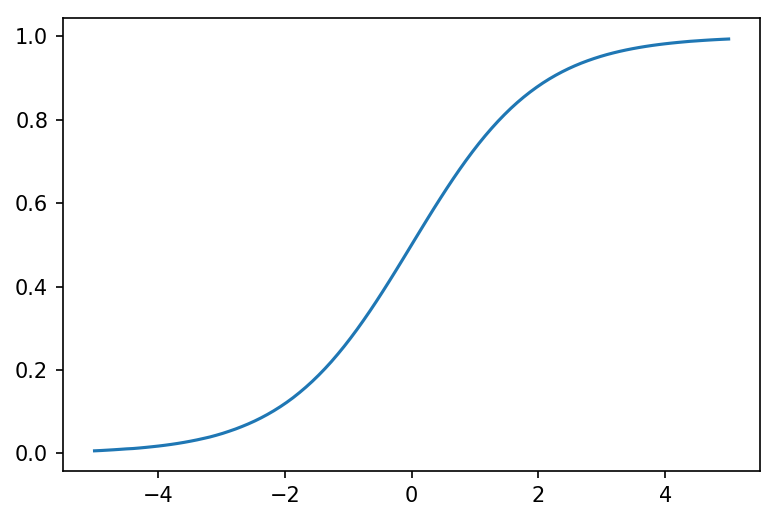

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x = torch.linspace(-5,5,100).requires_grad_()
y = layer(x[:,None])[:,0]
plt.figure(dpi=150)
plt.plot(x.detach().numpy(), y.detach().numpy())

As you would expect, gradients of the terms work as well (though not second derivatives, using just the implementation above).

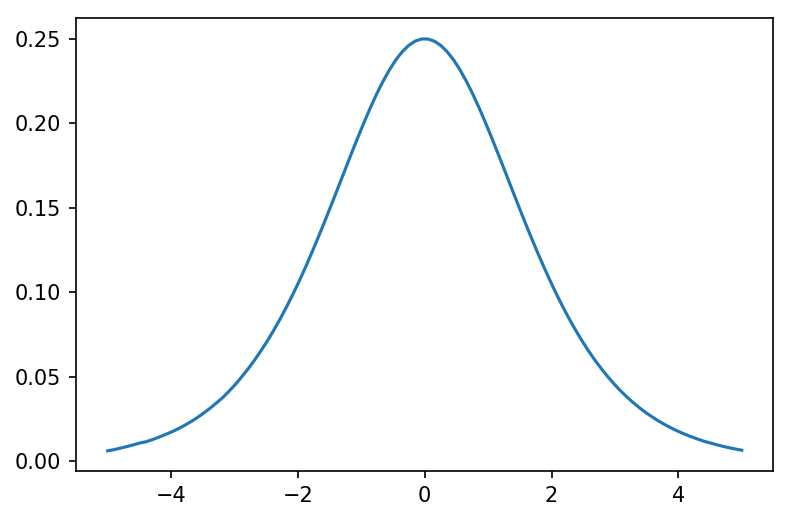

In [ ]:
y.sum().backward()
plt.figure(dpi=150)
plt.plot(x.detach().numpy(), x.grad.detach().numpy())

**Softmax**  The softmax function
\begin{equation}
\mathrm{softmax}(x) = \frac{\exp(x)}{\sum_{i=1}^n \exp(x_i)}
\end{equation}
is also given by the solution to an optimization problem, namely a similarly entropy-regularized linear objectivee
\begin{equation}
\begin{split}
\mathrm{softmax}(x) = \argmin_{z : 1^T z = 1} \;\; & -z^T x + \sum_{i=1}^n z_i \log z_i. \\
\end{split}
\end{equation}
This is again easy to write as an optimization layer.

In [ ]:
z = cp.Variable(10)
x = cp.Parameter(10)

f_ = lambda z,x: -z@x - cp.sum(cp.entr(z)) if isinstance(z, cp.Variable) else -z@x + z@torch.log(z)
h_ = lambda z,x: cp.sum(z) - 1 if isinstance(z, cp.Variable) else z.sum() - 1

layer = OptLayer([z], [x], f_, [], [h_])

Let's test the layer and it's gradient compared to the analytic form of softmax.

In [ ]:
import torch.nn.functional as F
x = torch.randn(20,10).requires_grad_()
y = layer(x)
y0 = nn.Softmax(dim=1)(x)
print("Mean absolute error of forward pass:", (y - y0).abs().mean().item())

Mean absolute error of forward pass: 3.955818829126656e-05


In [ ]:
r = torch.randn(*y0.shape)
(y*r).sum().backward()
print("Mean absolute error of backward pass:", (x.grad - autograd.grad((y0*r).sum(), x)[0]).abs().mean().item())

Mean absolute error of backward pass: 4.4939119106857106e-05


**Sparsemax** While recreating common nonlinearities that have a trivial analytic form provides some interesting insights, it's also of limited practical value, given how much faster the analytic form is than the use of general-purpose convex optimization tools.  As nice element of the convex optimization apporach, however, is that it can easily be extended to more general forms of nonlinearities, which can have several advantages in practice.  For instance, [[Martins and Astudillo, 2016](https://arxiv.org/abs/1602.02068)] proposed the sparsemax activation, which is given by the solution to the following optimization problem
\begin{equation}
\begin{split}
\mathrm{sparsemax}(x) = \argmin_{z} \;\; & \|z - x\|^2 \\
\mbox{subject to} \;\; & 1^T z = 1 \\
& z \geq 0.
\end{split}
\end{equation}
Implementing this as was done in the original paper requires a (straightforward, but still somewhat involved) formulation of a custom solver for this specific optimization problem, along with a derviation of the Jacobian.  Using our optimization layer, however, we could test out such a layer using a small amount of code.

In [ ]:
z = cp.Variable(10)
x = cp.Parameter(10)

f_ = lambda z,x : cp.sum_squares(z - x) if isinstance(z, cp.Variable) else torch.sum((x-z)**2)
g_ = lambda z,x : -z
h_ = lambda z,x: cp.sum(z) - 1 if isinstance(z, cp.Variable) else z.sum() - 1

layer = OptLayer([z], [x], f_, [g_], [h_])

In [ ]:
x = torch.randn(3,10).requires_grad_()
y = layer(x)
print(np.round(y.detach().numpy(),4))

[[-0.     -0.     -0.     -0.     -0.     -0.     -0.      1.     -0.
  -0.    ]
 [ 0.7871  0.      0.      0.      0.2129  0.      0.      0.      0.
   0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.9695  0.0305
   0.    ]]


Naturally, if you plan to use a layer frequently within a real network, it is reasonable to re-write it with a custom, fast solver (most likely with a native GPU implementation), but for quick experimentation of differentiable layers, tools like the code above (or more realistically, the cvxpylayers library) can be extremely useful.  And indeed, the same techniques and programming approaches also work very well (with proper specialization), when you _do_ want to code the more specailized, faster version.

### Learning convex polytopes

Let's consider one final (and nicely visual) example of a convex optimization problem: that of learning a polytope from data.  Specifically, let's consider the optimization layer
\begin{equation}
\begin{split}
\minimize_{z} \;\; &\|z-x\|^2 \\
\mbox{subject to} \;\; & G z \leq h
\end{split}
\end{equation}
i.e., the layer compute the closest point to $x$ within the polytope defined by $G z \leq h$.  Here, however, $G$ and $h$ can be considered as unknown parameters of the layer: we do not know an actual polytope for some given data (indeed, no "true" underlying polytope might exist), but instead suppose we are given pairs $(x^{(i)},y^{(i)})$ where $x^{(i)}$ is some original point and $y^{(i)}$ is it's projection onto some unknown set.  Because the layer is differentiable, we can use gradient descent to fit the $G$ and $h$ parameters to approximate this set, on the underlying data, via a polytope.  For convenience, we can easily wrap this into another PyTorch module that handles the details.

In [ ]:
class PolytopeProjection(nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.G = nn.Parameter(torch.randn(m,n))
        self.h = nn.Parameter(torch.ones(m))

        obj = lambda z,x,G,h : cp.sum_squares(z - x) if isinstance(z, cp.Variable) else torch.sum((x-z)**2)
        ineq = lambda z,x,G,h : G@z - h
        self.layer = OptLayer([cp.Variable(n)], [cp.Parameter(n), cp.Parameter((m,n)), cp.Parameter(m)],
                              obj, [ineq], [])

    def forward(self, x):
        return self.layer(x, self.G.expand(x.shape[0], *self.G.shape), self.h.expand(x.shape[0], *self.h.shape))

Now let's create some data, where in this case $x^{(i)}$ will be a 2D point, and $y^{(i)}$ will be its projection on to the unit $\ell_2$ ball.  Of course, we cannot exactly represent the unit ball as a polytope, but using gradient descent and our layer, we can approximate the sphere _for the given data_ as best as possible using this layer.

(-1.0998920500278473,
 1.0995387136936188,
 -1.0989443719387055,
 1.0795102775096894)

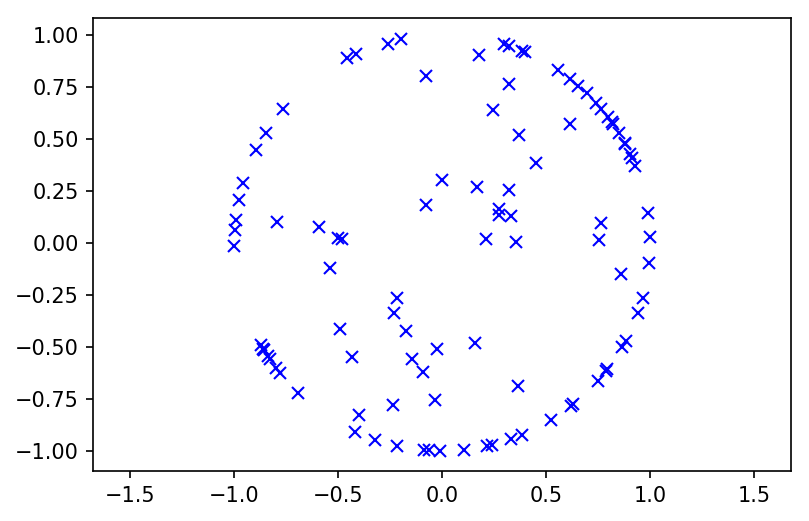

In [ ]:
p = 100
X = torch.randn(p, 2)
Y = X / X.norm(dim=1).clamp(min=1)[:,None]
plt.figure(dpi=150)
plt.plot(Y[:,0], Y[:,1],'bx')
plt.axis("equal")

In [ ]:
torch.manual_seed(0)
layer = PolytopeProjection(2, 20)

Let's first look at the (randomly initialized, but to be non-empty) polytope at initialization.

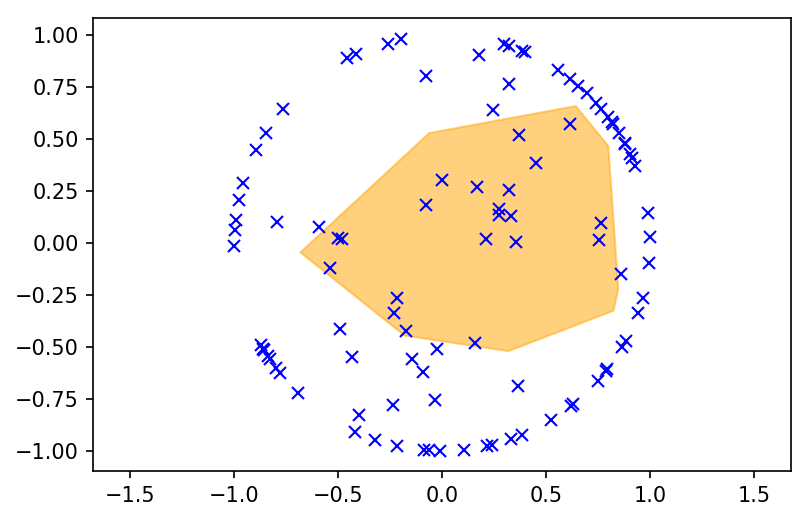

In [ ]:
from scipy.spatial import HalfspaceIntersection
from matplotlib.patches import Polygon

def plot_polytope(G, h, X):
    hs = HalfspaceIntersection(np.hstack((G.detach(),  -h[:,None].detach())), np.array([0.,0.]))
    pts = hs.intersections - hs.interior_point
    pts = pts[np.argsort(np.arctan2(pts[:,1],pts[:,0])),:] + hs.interior_point
    plt.fill(pts[:,0], pts[:,1], color="orange", alpha=0.5)
    plt.plot(X[:,0], X[:,1], 'bx')

plt.figure(dpi=150)
plot_polytope(layer.G, layer.h, Y)
plt.axis('equal');

Now let's optimize the polytope using Adam to minimize the distance between the points projected to the polytope and the points projected onto the unit ball.

In [ ]:
import torch.optim as optim
opt = optim.Adam(layer.parameters(), lr=1e-1)
for i in range(40):
    if i == 20:
        opt.param_groups[0]["lr"] = 1e-2
    loss = nn.MSELoss()(layer(X), Y)
    opt.zero_grad()
    loss.backward()
    opt.step()

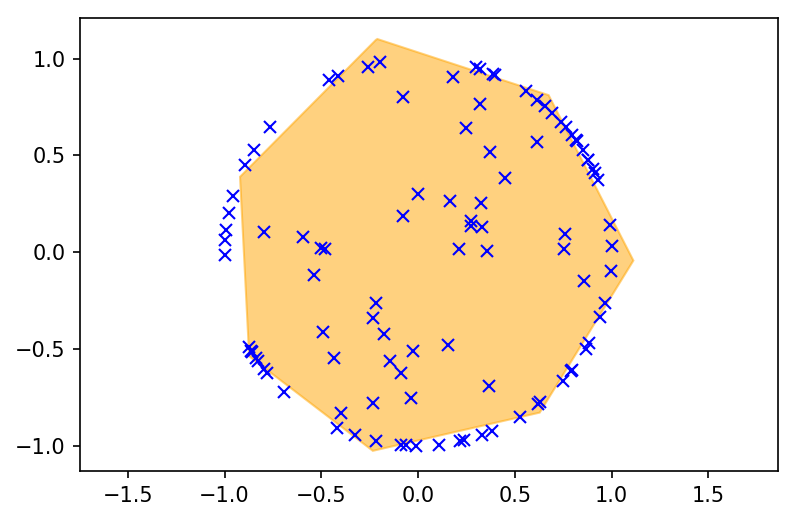

In [ ]:
plt.figure(dpi=150)
plot_polytope(layer.G, layer.h, Y)
plt.axis('equal');

Recall that according to our loss function we are not trying to "contain" the points in the polytope (like in a convex hull), but rather minimize the squared error between the point projected onto the polytope and the point projected onto the ball, which will result in some points being inside and some being outside the surface.  The fact that we can easily use gradient-based techniques to perform operations like this, and integrate them within deep architectures in general, is a powerful feature that is useful in a wide range of domains.